# Basic Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Other related imports

In [2]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import pipeline
from sklearn import linear_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df_train = pd.read_csv('train.csv')   #Upload train & test data sets
df_test = pd.read_csv('test.csv')

In [4]:
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
df_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


In [7]:
print(df_train.columns)
print(df_test.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [8]:
print(df_train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [9]:
print(df_test.isnull().sum())

id             0
keyword       26
location    1105
text           0
dtype: int64


In [10]:
df_train['target'].value_counts()*100/df_train.shape[0] #target column distribution 

target
0    57.034021
1    42.965979
Name: count, dtype: float64

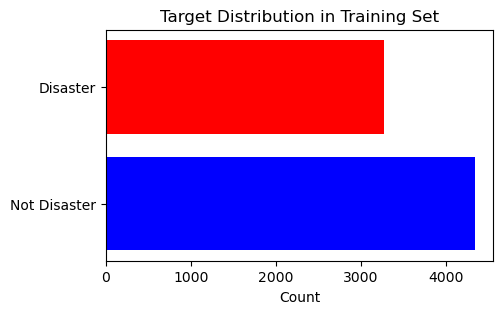

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))

# Get the value counts of the 'target' column in the df_train DataFrame
value_counts = df_train['target'].value_counts()

# Create a horizontal bar plot using the value counts
ax.barh(['Not Disaster', 'Disaster'], value_counts, color=['blue', 'red'])

ax.set_xlabel('Count')
ax.set_title('Target Distribution in Training Set')

plt.show()

C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


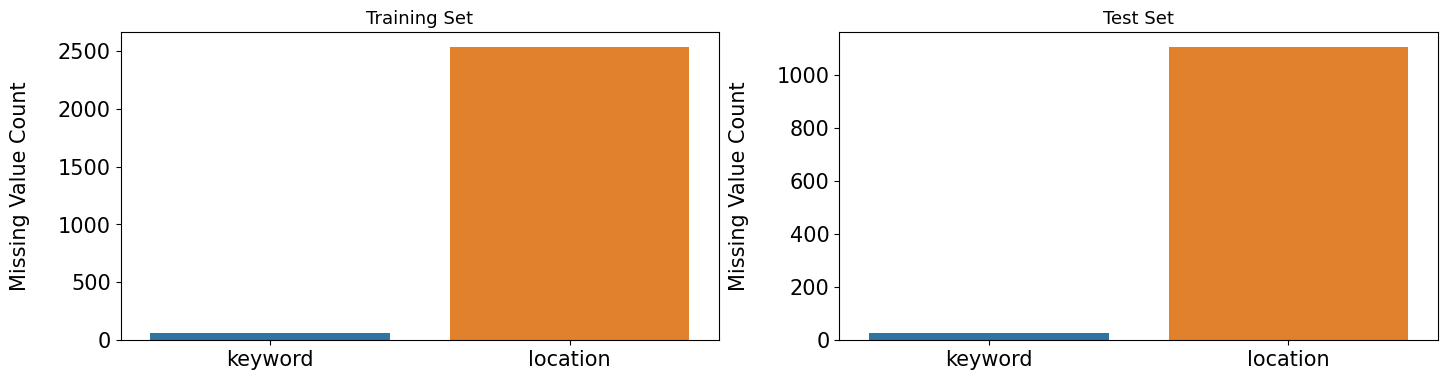

In [12]:
# list of columns with missing values
missing_cols = ['keyword', 'location']

# create bar plots for each set
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
for i, df in enumerate([df_train, df_test]):
    sns.barplot(x=missing_cols, y=df[missing_cols].isnull().sum().values, ax=axes[i])
    axes[i].set_ylabel('Missing Value Count', size=15, labelpad=20)
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    axes[i].set_title(['Training Set', 'Test Set'][i], fontsize=13)

# impute missing values with "no_{col}"
for df in [df_train, df_test]:
    df[missing_cols] = df[missing_cols].fillna(f'no_{{col}}')

plt.show()

# Missing values handling

In [13]:
#Since Location & Keyword are not important to NLP disaster Tweet I Deleted those 2 columns

In [14]:
del df_train['keyword']
del df_train['location']

In [15]:
df_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


# Clear texts using Regex

In [16]:
def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = re.sub(r'https?://\S+', '', text) # remove URLs
    text = re.sub(r"#", "", text)
    return text

In [17]:
clean_text("Be AWARE storm is comming #Breaking_News !!!!")

'be aware storm is comming breakingnews '

In [18]:
#apply regex clean text function to training data
df_train['text'] = df_train['text'].apply(clean_text) 

In [19]:
# Removing Stopwords
stop_words = set(stopwords.words('english'))

# Add custom words to the set
custom_stop_words = {"i'm", '&amp;', 'https', 'i', '-','2','3','70','_'}
stop_words.update(custom_stop_words)

# Define a function to remove stop words from a string
def remove_stopwords(text):
    text = " ".join(word.lower() for word in text.split() if word.lower() not in stop_words)
    return text

In [20]:
#apply remove stopwords function to train column of training data
df_train['text'] = df_train['text'].apply(remove_stopwords)

In [21]:
remove_stopwords("Be AWARE storm is comming #Breaking_News !!!!")

'aware storm comming #breaking_news !!!!'

In [22]:
#text column data after the preprocessing
df_train['text'].head(10)  

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    13000 people receive wildfires evacuation orde...
4    got sent photo ruby alaska smoke wildfires pou...
5    rockyfire update california hwy 20 closed dire...
6    flood disaster heavy rain causes flash floodin...
7                           im top hill see fire woods
8    theres emergency evacuation happening building...
9                        im afraid tornado coming area
Name: text, dtype: object

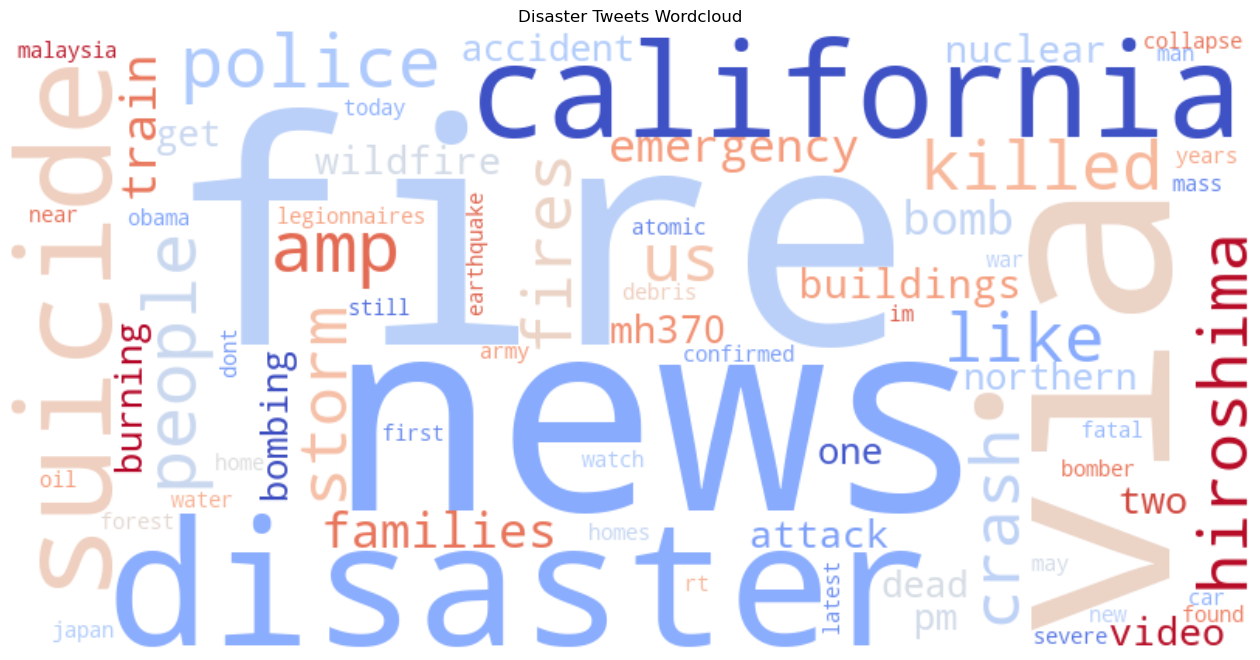

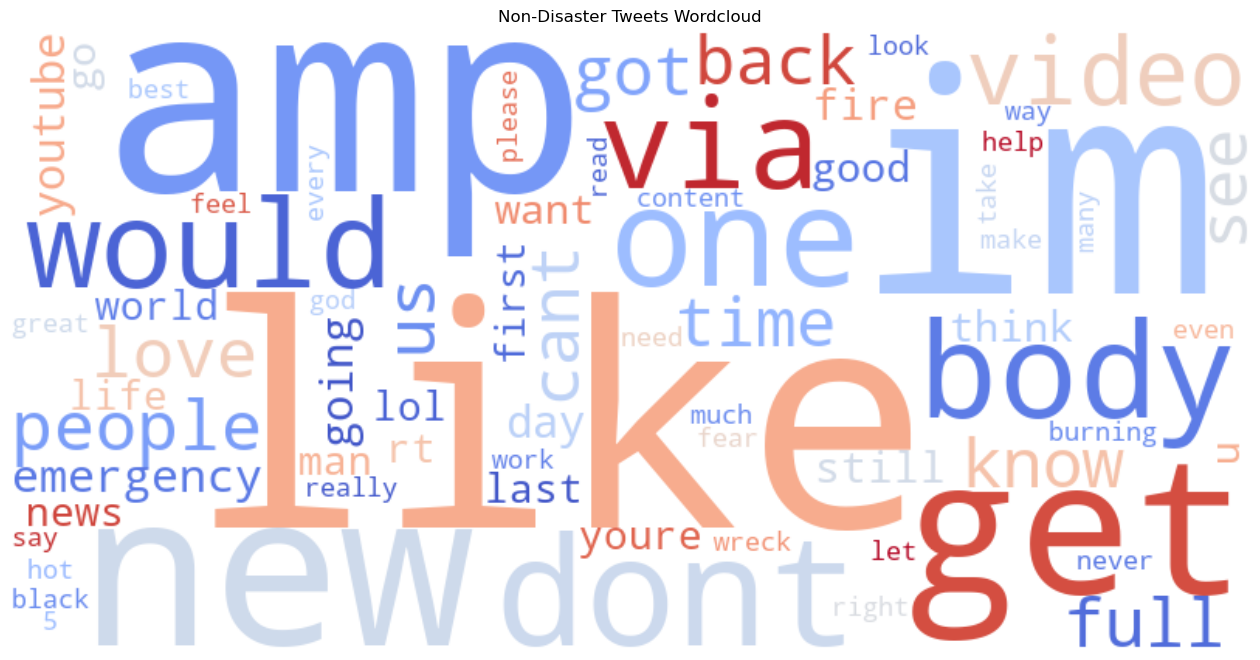

In [23]:
#function to generate wordcloud
def generate_wordcloud(text, title, max_words = 70):
   # Create counter object to count the occurrences of each word
    word_counts = Counter(text.split())

    # Get the most common words and their counts
    common_words = dict(word_counts.most_common(max_words))

    # Create a WordCloud object with some parameters
    wordcloud = WordCloud(width=800, height=400, max_font_size=200, 
                          background_color="white", colormap = 'coolwarm').generate_from_frequencies(common_words)

    # Display the generated image with matplotlib
    plt.figure(figsize=(16, 9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate a wordcloud for disaster
text1 = " ".join(review for review in df_train[df_train['target']==1].text)
generate_wordcloud(text1, 'Disaster Tweets Wordcloud')

# Generate a wordcloud for target=0
text0 = " ".join(review for review in df_train[df_train['target']==0].text)
generate_wordcloud(text0, 'Non-Disaster Tweets Wordcloud')

In [24]:
x = df_train['text']
y = df_train['target']

In [25]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=111222) 

In [26]:
vectorizer = TfidfVectorizer(stop_words ='english')
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.transform(x_test)


In [27]:
X_train.shape

(6090, 18724)

# Applying ML models

# Support Vector Machine Model

In [28]:
svm_model = svm.SVC().fit(X_train, y_train)
svm_pred_train = svm_model.predict(X_train)
svm_pred_test = svm_model.predict(X_test)
accuracy_train_svm = accuracy_score(svm_pred_train, y_train)
accuracy_test_svm = accuracy_score(svm_pred_test, y_test)

print(f'Training accuracy {accuracy_train_svm: .3f}')
print(f'Testing accuracy {accuracy_test_svm: .3f}')

Training accuracy  0.974
Testing accuracy  0.805


In [29]:
model_svm_best = svm.SVC()  
print(model_svm_best)  #Display parameters
model_svm_best.fit(X_train, y_train) #train
pred_svm = model_svm_best.predict(X_test)
print ("Classification Report =")
print (classification_report (y_test, pred_svm))
print ("Confusion Matrix =")
print(confusion_matrix(y_test, pred_svm))

SVC()
Classification Report =
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       877
           1       0.83      0.67      0.75       646

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523

Confusion Matrix =
[[790  87]
 [210 436]]


# Decision Tree Model

In [30]:
dt_model = DecisionTreeClassifier().fit(X_train, y_train)
dt_pred_train = dt_model.predict(X_train)
dt_pred_test = dt_model.predict(X_test)
accuracy_train_dt = accuracy_score(dt_pred_train, y_train)
accuracy_test_dt = accuracy_score(dt_pred_test, y_test)

print(f'Training accuracy {accuracy_train_dt: .3f}')
print(f'Testing accuracy {accuracy_test_dt: .3f}')

Training accuracy  0.997
Testing accuracy  0.718


In [31]:
model_dt_best = DecisionTreeClassifier() 
print(model_dt_best)  #Display parameters
model_dt_best.fit(X_train, y_train) #train
pred_dt = model_dt_best.predict(X_test)
print ("Classification Report =")
print (classification_report (y_test, pred_dt))
print ("Confusion Matrix =")
print(confusion_matrix(y_test, pred_dt))

DecisionTreeClassifier()
Classification Report =
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       877
           1       0.66      0.68      0.67       646

    accuracy                           0.72      1523
   macro avg       0.71      0.71      0.71      1523
weighted avg       0.72      0.72      0.72      1523

Confusion Matrix =
[[653 224]
 [204 442]]


# K Nearest Neighbours Model

In [32]:
knn_model = KNeighborsClassifier().fit(X_train, y_train)
knn_pred_train = knn_model.predict(X_train)
knn_pred_test = knn_model.predict(X_test)
accuracy_train_knn = accuracy_score(knn_pred_train, y_train)
accuracy_test_knn = accuracy_score(knn_pred_test, y_test)

print(f'Training accuracy {accuracy_train_knn: .3f}')
print(f'Testing accuracy {accuracy_test_knn: .3f}')

Training accuracy  0.828
Testing accuracy  0.761


In [33]:
model_knn_best = KNeighborsClassifier()
print(model_knn_best)  #Display parameters
model_knn_best.fit(X_train, y_train) #train
pred_knn = model_knn_best.predict(X_test)
print ("Classification Report =")
print (classification_report (y_test, pred_knn))
print ("Confusion Matrix =")
print(confusion_matrix(y_test, pred_knn))

KNeighborsClassifier()
Classification Report =
              precision    recall  f1-score   support

           0       0.73      0.93      0.82       877
           1       0.84      0.54      0.66       646

    accuracy                           0.76      1523
   macro avg       0.79      0.73      0.74      1523
weighted avg       0.78      0.76      0.75      1523

Confusion Matrix =
[[812  65]
 [299 347]]


#  RandomForest Model

In [34]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)
accuracy_train_rf = accuracy_score(rf_pred_train, y_train)
accuracy_test_rf = accuracy_score(rf_pred_test, y_test)

print(f'Training accuracy {accuracy_train_rf: .3f}')
print(f'Testing accuracy {accuracy_test_rf: .3f}')

Training accuracy  0.997
Testing accuracy  0.794


In [35]:
model_rf_best = RandomForestClassifier()
print(model_rf_best)  #Display parameters
model_rf_best.fit(X_train, y_train) #train
pred_rf = model_rf_best.predict(X_test)
print ("Classification Report =")
print (classification_report (y_test, pred_rf))
print ("Confusion Matrix =")
print(confusion_matrix(y_test, pred_rf))

RandomForestClassifier()
Classification Report =
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       877
           1       0.80      0.69      0.74       646

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Confusion Matrix =
[[763 114]
 [202 444]]


#  Logistic Regression Model

In [36]:
lr_model = LogisticRegression().fit(X_train, y_train)
lr_pred_train = lr_model.predict(X_train)
lr_pred_test = lr_model.predict(X_test)
accuracy_train_lr = accuracy_score(lr_pred_train, y_train)
accuracy_test_lr = accuracy_score(lr_pred_test, y_test)

print(f'Training accuracy {accuracy_train_lr: .3f}')
print(f'Testing accuracy {accuracy_test_lr: .3f}')

Training accuracy  0.898
Testing accuracy  0.809


In [37]:
model_lr_best = LogisticRegression()
print(model_lr_best)  #Display parameters
model_lr_best.fit(X_train, y_train) #train
pred_lr = model_lr_best.predict(X_test)
print ("Classification Report =")
print (classification_report (y_test, pred_lr))
print ("Confusion Matrix =")
print(confusion_matrix(y_test, pred_lr))

LogisticRegression()
Classification Report =
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       877
           1       0.82      0.70      0.76       646

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Confusion Matrix =
[[781  96]
 [195 451]]


# Model Comparision using cross validation & mean accuracy

In [38]:
from sklearn.model_selection import cross_val_score

# Define models
models = {
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression' : LogisticRegression()
}

# Evaluate models using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[model_name] = scores.mean()

# Print mean accuracy scores for each model
for model_name, score in results.items():
    print(f"{model_name}: Mean Accuracy = {score:.3f}")

# Choose the model with the highest mean accuracy
best_model = max(results, key=results.get)
print(f"\nBest Model: {best_model}")

SVM: Mean Accuracy = 0.783
KNN: Mean Accuracy = 0.765
Decision Tree: Mean Accuracy = 0.735
Random Forest: Mean Accuracy = 0.771
Logistic Regression: Mean Accuracy = 0.792

Best Model: Logistic Regression


# Create Submission File

In [46]:
# Train the best model on the entire training dataset
best_Model = models[best_model]
best_Model.fit(X_train, y_train)


# Use the trained model to make predictions on the test dataset
test_predictions = best_Model.predict(vectorizer.transform(df_test['text']))

# Create a DataFrame containing the predicted labels for the test dataset
submission_df = pd.DataFrame({'id': df_test['id'], 'target': test_predictions})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission9.csv', index=False)

# Final model evaluation

In [39]:
#Since the Logistic regression is best model
model_pipeline = pipeline.Pipeline([('vector', vectorizer),('clf', LogisticRegression())]) 

In [40]:
model_pipeline.fit(x_train,y_train)

Pipeline(steps=[('vector', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression())])

In [41]:
predict_value = model_pipeline.predict(x_test)

In [42]:
from sklearn import metrics
metrics.accuracy_score(y_test,predict_value)*100

80.8929743926461

In [43]:
metrics.confusion_matrix(y_test,predict_value)

array([[781,  96],
       [195, 451]], dtype=int64)

In [52]:
model_pipeline.predict(['There is a wildfire near my house'])

array([1], dtype=int64)

In [53]:
model_pipeline.predict(['The Sky is Stuning'])

array([0], dtype=int64)

# Create pickle file

In [45]:
import pickle

In [46]:
pickle_file = open('NLP_Final.pkl','wb')
pickle.dump(model_pipeline,pickle_file)
pickle_file.close()

In [47]:
#Load the pickle file
model_loaded = pickle.load(open('NLP_Final.pkl','rb'))  

In [48]:
model_loaded

Pipeline(steps=[('vector', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression())])

In [49]:
model_loaded.predict(['There is a wildfire near my house'])

array([1], dtype=int64)